In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from shapely import wkt
import scipy.stats as stats

%matplotlib inline

In [2]:
# load data
dv_trips_2025_10 = pd.read_csv("202510-divvy-tripdata.csv")
dv_trips_2025_9 = pd.read_csv("202509-divvy-tripdata.csv")
dv_trips_2025_8 = pd.read_csv("202508-divvy-tripdata.csv")
dv_trips_2025 = pd.concat([dv_trips_2025_8, dv_trips_2025_9, dv_trips_2025_10], axis = 0)

dv_stations = pd.read_csv("Divvy_Bicycle_Stations_20251114.csv")
zones = pd.read_csv("Boundaries_-_Zoning_Districts_(current)_20251124.csv")

In [3]:
dv_stations = (dv_stations
               .drop(["ID", "Short Name", "Status", "Location", "Total Docks", "Latitude", "Longitude"], axis = 1)
               .rename(columns = {"Station Name": "station_name", "Docks in Service": "Docks"}))

# convert zoning types data of areas in chicago city, preparing for spatial join with the location of bike stations
zones["geometry"] = zones["the_geom"].apply(wkt.loads)
zones = gpd.GeoDataFrame(zones, geometry="geometry", crs = "EPSG:4326")
zones = zones.drop(["the_geom", "CASE_NUMBE", "CASE_TYPE", "ZONING_ID", "ZONE_TYPE", "EDIT_STATU", "CREATE_DAT", "EDIT_DATE", 
                    "PD_PREFIX", "PD_NUM", "COMMENTS", "ORDINANCE_", "ORDINANCE1", "ZONING_REL", "SHAPE_AREA", 
                    "SHAPE_LEN", "PEDSTREET_","OBJECTID","GLOBALID",
                    "PMD_SUB_AR", "OVERRIDE_C", "OVERRIDE_R", "CLERK_URL", "CLERK_DOCN"], axis = 1)

# convert the zone class into full type name
zones["prefix"] = zones["ZONE_CLASS"].str.extract(r"^([A-Z]+)")
prefix_to_full = {
    "RS": "Residential Single-Unit",
    "RT": "Residential Two-Flat / Townhouse",
    "RM": "Residential Multi-Unit",
    
    "B":  "Business District",
    "C":  "Commercial District",

    "DX": "Downtown Mixed-Use",
    "DC": "Downtown Core District",
    "DR": "Downtown Residential",
    "DS": "Downtown Service",

    "M":   "Manufacturing",
    "PMD": "Planned Manufacturing District",

    "POS": "Public Open Space",
    
    "PD":  "Planned Development",
    "T":   "Transportation District",
}
zones["full_name"] = zones["prefix"].map(prefix_to_full)
# since there's too many categories which is hard to analyze them all, I aggregate them into more general group.
full_to_category = {
    "Residential Single-Unit": "Residential",
    "Residential Two-Flat / Townhouse": "Residential",
    "Residential Multi-Unit": "Residential",
    "Downtown Residential": "Residential",

    "Business District": "Commercial",
    "Commercial District": "Commercial",

    "Downtown Mixed-Use": "Downtown",
    "Downtown Core District": "Downtown",
    "Downtown Service": "Downtown",

    "Manufacturing": "Industrial",
    "Planned Manufacturing District": "Industrial",

    "Public Open Space": "Open Space",

    "Planned Development": "Planned Development",
    "Transportation District": "Transportation",
}

zones["category"] = zones["full_name"].map(full_to_category)

In [10]:
dv_trips_2025_cleaned = dv_trips_2025[~(dv_trips_2025["start_station_name"].isna() & dv_trips_2025["end_station_name"].isna())].copy()

In [11]:
# convert the start and end date into datetime object and extract the start hour, start date and start daytype from it
dv_trips_2025_cleaned["started_at"] = pd.to_datetime(dv_trips_2025_cleaned["started_at"])
dv_trips_2025_cleaned["ended_at"] = pd.to_datetime(dv_trips_2025_cleaned["ended_at"])
dv_trips_2025_cleaned["start_hour"] = dv_trips_2025_cleaned["started_at"].dt.hour
dv_trips_2025_cleaned["start_date"] = dv_trips_2025_cleaned["started_at"].dt.date
dv_trips_2025_cleaned["start_day_type"] = dv_trips_2025_cleaned["started_at"].dt.weekday.map(
    lambda x: "weekend" if x >= 5 else "weekday"
)

In [12]:
# This code aims to calculate the inflow information of a station by date, by hour, and by weekday/weekend
dv_station_st = (dv_trips_2025_cleaned
                           .groupby(["start_station_name", "start_date", "start_day_type", "start_hour"], observed = True)
                           .agg(Bikes_out = ("ride_id", "count"),
                                Electric_out=("rideable_type", lambda x: np.sum(x == "electric_bike")),
                                Classic_out=("rideable_type", lambda x: np.sum(x == "classic_bike"))))
dv_station_st = dv_station_st.reset_index()

In [13]:
# create the end hour, end date and end daytype column fo furthur groupy and merge operation
dv_trips_2025_cleaned["end_hour"] = dv_trips_2025_cleaned["ended_at"].dt.hour
dv_trips_2025_cleaned["end_date"] = dv_trips_2025_cleaned["ended_at"].dt.date
dv_trips_2025_cleaned["end_day_type"] = dv_trips_2025_cleaned["ended_at"].dt.weekday.map(
    lambda x: "weekend" if x >= 5 else "weekday"
)

In [14]:
# repeat the same procedure to calculate the outflow information of a station by date, by hour, and by weekday/weekend
dv_station_ed = (dv_trips_2025_cleaned
                           .groupby(["end_station_name", "end_date", "end_day_type", "end_hour"], observed = True)
                           .agg(Bikes_in = ("ride_id", "count"),
                                Electric_in=("rideable_type", lambda x: np.sum(x == "electric_bike")),
                                Classic_in=("rideable_type", lambda x: np.sum(x == "classic_bike"))))
dv_station_ed = dv_station_ed.reset_index()

In [15]:
station_summary = dv_station_st.merge(dv_station_ed, 
                                           left_on = ["start_station_name", "start_date", "start_day_type", "start_hour"], 
                                           right_on = ["end_station_name", "end_date", "end_day_type", "end_hour"],
                                           how = "outer" )

# Since an outer join is used, some records contain missing values when a station has only inflow or only outflow data 
# for a given date, hour, or day type (weekday/weekend). To ensure that both inflow and outflow information can be analyzed together, 
# these records are retained and the station name, date, day type, and hour are reconstructed by combining the corresponding start and end fields. 
# When one side is missing, the available value is used.
station_summary["station_name"] = station_summary["start_station_name"].combine_first(station_summary["end_station_name"])
station_summary["date"] = station_summary["start_date"].combine_first(station_summary["end_date"])
station_summary["day_type"] = station_summary["start_day_type"].combine_first(station_summary["end_day_type"])
station_summary["hour"] = station_summary["start_hour"].combine_first(station_summary["end_hour"])

station_summary = station_summary.drop(["start_station_name", 
                                        "end_station_name",
                                        "start_date",
                                        "end_date",
                                        "start_day_type",
                                        "end_day_type",
                                        "start_hour",
                                        "end_hour"], axis = 1)
# nan values for Bikes in or out indicates no bike inflow or outflow, fill them with 0
station_summary[["Bikes_in", "Bikes_out", "Electric_in", "Classic_in", "Electric_out", "Classic_out"]] = station_summary[["Bikes_in", "Bikes_out", "Electric_in", "Classic_in", "Electric_out", "Classic_out"]].fillna(0)
# calculate hourly total trips for each station each day on weekday or weekend in three month
# Also calculate total trips for classic and electric bikes for later analysis
station_summary["hourly_total_trips"] = station_summary["Bikes_in"] + station_summary["Bikes_out"]
station_summary["hourly_total_electric_trips"] = station_summary["Electric_in"] + station_summary["Electric_out"]
station_summary["hourly_total_classic_trips"] = station_summary["Classic_in"] + station_summary["Classic_out"]

# group by station name, day type and hour, use aggregation to calculate the sum of three month for all indicators 
# also calculate the unique days having records, use for later daily mean calculation
station_summary = (station_summary.groupby(["station_name", "day_type", "hour"], observed = True)
                   .agg(hourly_total_trips_sum = ("hourly_total_trips", "sum"),
                        hourly_bikes_in_sum = ("Bikes_in", "sum"),
                        hourly_bikes_out_sum = ("Bikes_out", "sum"),
                        hourly_total_electric_trips_sum = ("hourly_total_electric_trips", "sum"),
                        hourly_total_classic_trips_sum = ("hourly_total_classic_trips", "sum"),
                        days = ("date", "nunique"))).reset_index()

# divide the sum of three month by number of days for each indicator to calculate their mean for each day
# subtract mean daily hourly bikes inflow by mean hourly bikes outflow to get the mean hourly bikes net flow
station_summary["mean_hourly_total_trips"] = station_summary["hourly_total_trips_sum"] / station_summary["days"]
station_summary["mean_hourly_bikes_in"] = station_summary["hourly_bikes_in_sum"] / station_summary["days"]
station_summary["mean_hourly_bikes_out"] = station_summary["hourly_bikes_out_sum"] / station_summary["days"]
station_summary["mean_hourly_net_flow"] = station_summary["mean_hourly_bikes_in"] - station_summary["mean_hourly_bikes_out"]
# drop columns that are no longer needed, sort the value by station name and hour for later plotting
station_summary = station_summary.drop(["hourly_total_trips_sum", "hourly_bikes_in_sum", "hourly_bikes_out_sum"], axis = 1)
station_summary = station_summary.sort_values(by = ["station_name", "hour"])
station_summary.head()

,station_name,day_type,hour,hourly_total_electric_trips_sum,hourly_total_classic_trips_sum,days,mean_hourly_total_trips,mean_hourly_bikes_in,mean_hourly_bikes_out,mean_hourly_net_flow
0,2112 W Peterson Ave,weekday,0.0,4.0,0.0,4,1.0,0.750000,0.250000,0.500000
18,2112 W Peterson Ave,weekend,1.0,2.0,0.0,1,2.0,2.000000,0.000000,2.000000
1,2112 W Peterson Ave,weekday,6.0,0.0,2.0,2,1.0,0.500000,0.500000,0.000000
19,2112 W Peterson Ave,weekend,6.0,1.0,1.0,2,1.0,0.500000,0.500000,0.000000
2,2112 W Peterson Ave,weekday,7.0,3.0,3.0,6,1.0,0.166667,0.833333,-0.666667


In [16]:
# get unique station names and their location (longitude and latitude) from the trip data
start_station_coords = (dv_trips_2025_cleaned[["start_station_name", "start_lat", "start_lng"]]
                        .rename(columns = {"start_station_name": "station_name", "start_lat": "lat", "start_lng": "lng"}))
start_station_coords = start_station_coords.drop_duplicates(subset = ["station_name"]).dropna()
end_station_coords = (dv_trips_2025_cleaned[["end_station_name", "end_lat", "end_lng"]]
                        .rename(columns = {"end_station_name": "station_name", "end_lat": "lat", "end_lng": "lng"}))
end_station_coords = end_station_coords.drop_duplicates(subset = ["station_name"]).dropna()
station_coords = pd.concat([start_station_coords, end_station_coords], axis = 0)
station_coords = station_coords.drop_duplicates(subset = ["station_name"])
station_coords_np = station_coords[["lat", "lng"]].to_numpy()
station_coords.head()

,station_name,lat,lng
240,California Ave & Milwaukee Ave,41.922695,-87.697153
515,Sayre Ave & Diversey Ave,41.930980,-87.801060
535,Milwaukee Ave & Fullerton Ave,41.924690,-87.700600
648,Peoria St & Kinzie St,41.888960,-87.649730
658,California Ave & Division St,41.903029,-87.697474


In [17]:
# combine the station information summary with station coordinates, used for both plotting and spatial join with land use type data
station_summary = station_coords.merge(station_summary, on = "station_name", how = "left")
station_summary.head()

,station_name,lat,lng,day_type,hour,hourly_total_electric_trips_sum,hourly_total_classic_trips_sum,days,mean_hourly_total_trips,mean_hourly_bikes_in,mean_hourly_bikes_out,mean_hourly_net_flow
0,California Ave & Milwaukee Ave,41.922695,-87.697153,weekday,0.0,74.0,18.0,43,2.139535,0.860465,1.279070,-0.418605
1,California Ave & Milwaukee Ave,41.922695,-87.697153,weekend,0.0,80.0,54.0,26,5.153846,2.076923,3.076923,-1.000000
2,California Ave & Milwaukee Ave,41.922695,-87.697153,weekday,1.0,36.0,20.0,29,1.931034,0.724138,1.206897,-0.482759
3,California Ave & Milwaukee Ave,41.922695,-87.697153,weekend,1.0,57.0,41.0,25,3.920000,1.360000,2.560000,-1.200000
4,California Ave & Milwaukee Ave,41.922695,-87.697153,weekday,2.0,21.0,7.0,20,1.400000,0.950000,0.450000,0.500000


In [18]:
# conver the station summary data into geodataframe and use the coordinates of stations as geometry
# do spatial join with zone data, which contains the boundaries and land use type of each area in chicago city
# now each station has a corresponding land use type of the area where it is located
stations_summary_gdf = gpd.GeoDataFrame(
    station_summary,
    geometry=gpd.points_from_xy(station_summary["lng"], station_summary["lat"]),
    crs="EPSG:4326"
)
joined = gpd.sjoin(stations_summary_gdf, zones, how="inner", predicate="within")
joined = joined.drop(["index_right"], axis = 1)

# add station docks number to the data, for calculating net flow per dock
joined = joined.merge(dv_stations, on = "station_name", how = "left")
joined["Docks"] = joined["Docks"].fillna(joined["Docks"].mean().round(1))
joined["usage_per_dock"] = joined["mean_hourly_total_trips"] /  joined["Docks"]
joined["net_flow_per_dock"] = joined["mean_hourly_net_flow"] /  joined["Docks"]
joined.head()

,station_name,lat,lng,day_type,hour,hourly_total_electric_trips_sum,hourly_total_classic_trips_sum,days,mean_hourly_total_trips,mean_hourly_bikes_in,mean_hourly_bikes_out,mean_hourly_net_flow,geometry,ZONE_CLASS,prefix,full_name,category,Docks,usage_per_dock,net_flow_per_dock
0,California Ave & Milwaukee Ave,41.922695,-87.697153,weekday,0.0,74.0,18.0,43,2.139535,0.860465,1.279070,-0.418605,POINT (-87.69715 41.9227),C1-1,C,Commercial District,Commercial,15.0,0.142636,-0.027907
1,California Ave & Milwaukee Ave,41.922695,-87.697153,weekend,0.0,80.0,54.0,26,5.153846,2.076923,3.076923,-1.000000,POINT (-87.69715 41.9227),C1-1,C,Commercial District,Commercial,15.0,0.343590,-0.066667
2,California Ave & Milwaukee Ave,41.922695,-87.697153,weekday,1.0,36.0,20.0,29,1.931034,0.724138,1.206897,-0.482759,POINT (-87.69715 41.9227),C1-1,C,Commercial District,Commercial,15.0,0.128736,-0.032184
3,California Ave & Milwaukee Ave,41.922695,-87.697153,weekend,1.0,57.0,41.0,25,3.920000,1.360000,2.560000,-1.200000,POINT (-87.69715 41.9227),C1-1,C,Commercial District,Commercial,15.0,0.261333,-0.080000
4,California Ave & Milwaukee Ave,41.922695,-87.697153,weekday,2.0,21.0,7.0,20,1.400000,0.950000,0.450000,0.500000,POINT (-87.69715 41.9227),C1-1,C,Commercial District,Commercial,15.0,0.093333,0.033333


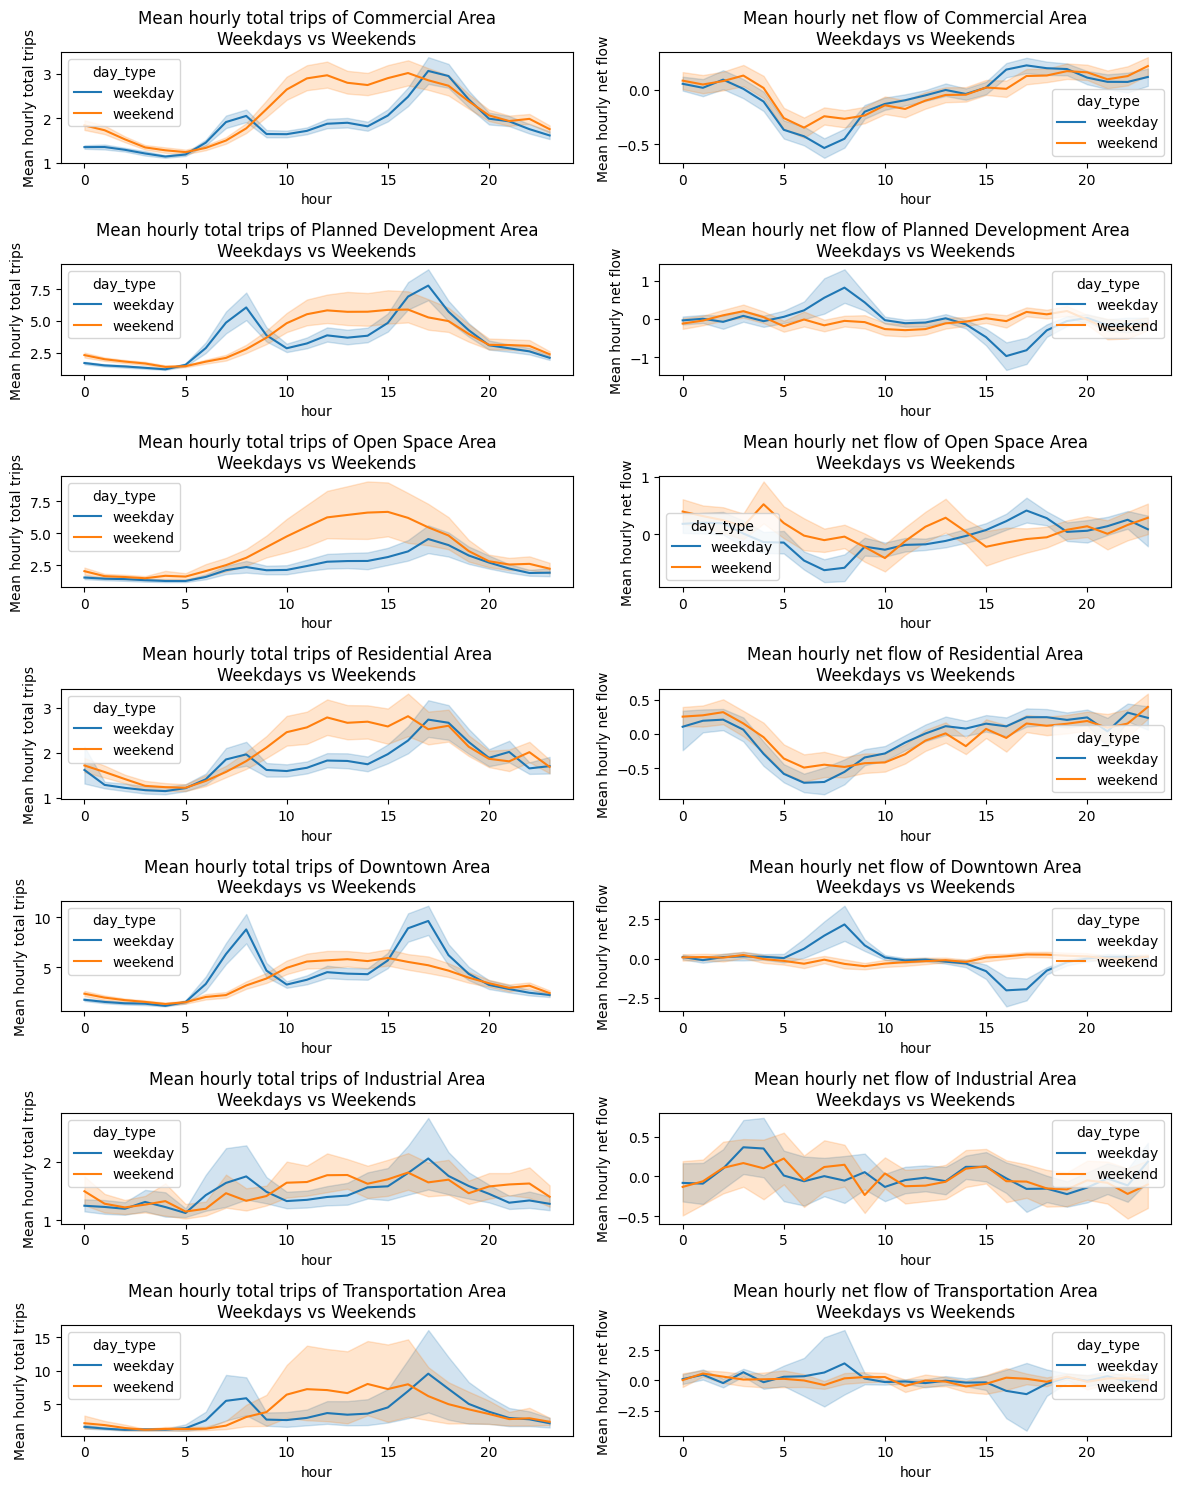

In [40]:
# Draw mean hourly total trips and mean hourly net flow for stations of each land use type, weekday vs weekend
indicators = ["mean_hourly_total_trips", "mean_hourly_net_flow"]
ind_names = ["Mean hourly total trips", "Mean hourly net flow"]
cats = joined["category"].unique()
rows = len(cats)
fig, ax = plt.subplots(rows, 2, figsize=(12, 15))
for i, cat in enumerate(cats):
    for j, ind in enumerate(indicators):
        subset = joined[joined["category"] == cat]
        sns.lineplot(data = subset, x = "hour", y = ind, hue = "day_type", ax = ax[i, j])
        ax[i, j].set_title(f"{ind_names[j]} of {cat} Area\nWeekdays vs Weekends")
        ax[i, j].set_xlabel("hour")
        ax[i, j].set_ylabel(ind_names[j])
plt.tight_layout()
plt.show()

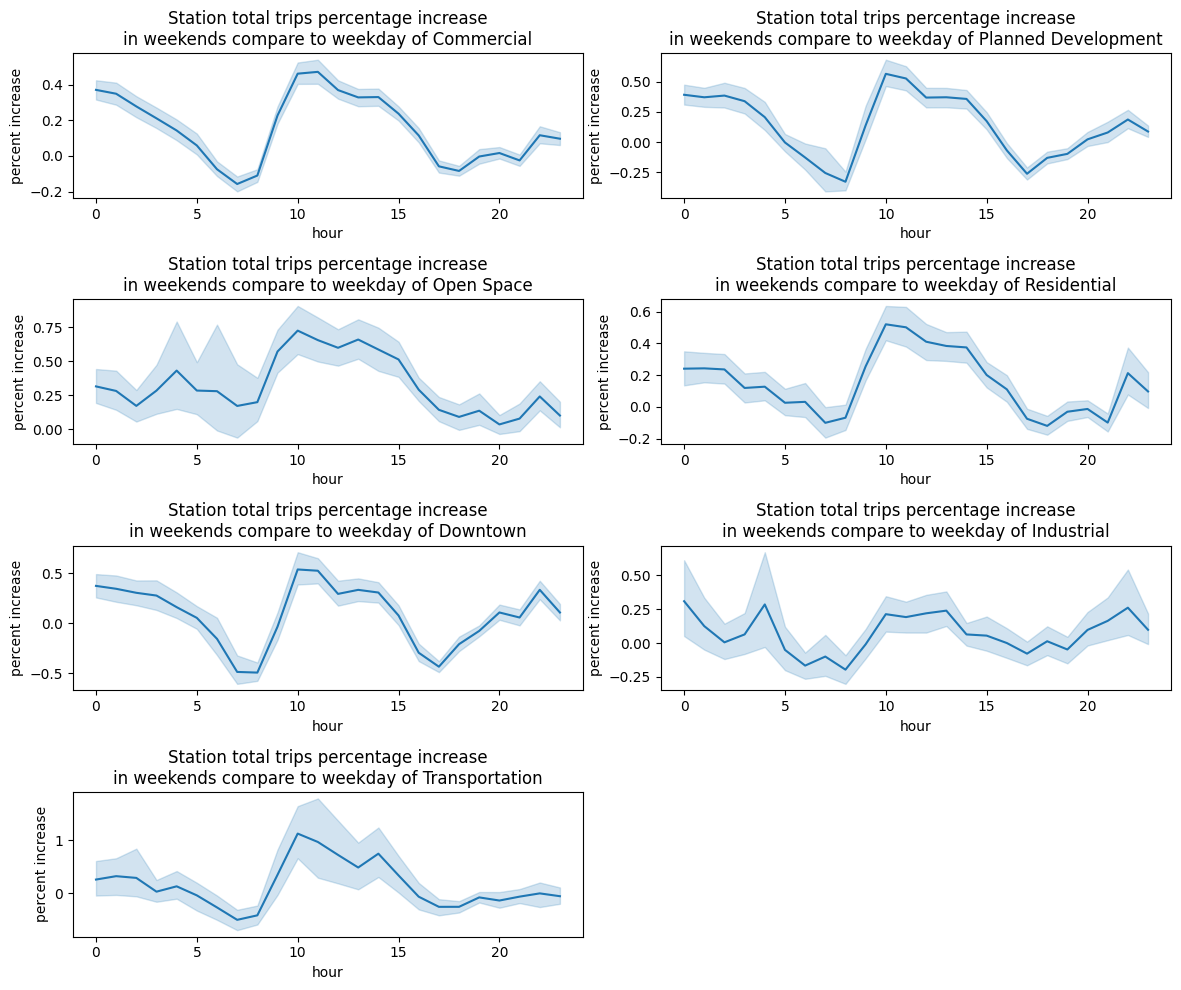

In [41]:
# draw percentage increase in hourly total trips in weekends compare to weekdays of each land use type
# to better understand the increase or decrease amount of use in weekend compare to weekdays
joined_copy = joined[["station_name", "day_type", "hour", "mean_hourly_total_trips", "mean_hourly_net_flow", "category"]]
wide = joined_copy.pivot_table(
    index=["station_name", "hour", "category"],   
    columns="day_type",               
    values="mean_hourly_total_trips",
)
wide = wide.dropna()
wide = wide.reset_index()
wide["pct_increase"] = (wide["weekend"] - wide["weekday"]) / wide["weekday"]


fig, ax = plt.subplots(4, 2, figsize=(12, 10))
ax = ax.flatten()
fig.delaxes(ax[-1])
ax = ax[:-1]
for i, cat in enumerate(cats):
    subset = wide[wide["category"] == cat]
    sns.lineplot(data = subset, x = "hour", y = "pct_increase", ax = ax[i])
    ax[i].set_title(f"Station total trips percentage increase\nin weekends compare to weekday of {cat}")
    ax[i].set_xlabel("hour")
    ax[i].set_ylabel("percent increase")
plt.tight_layout()
plt.show()

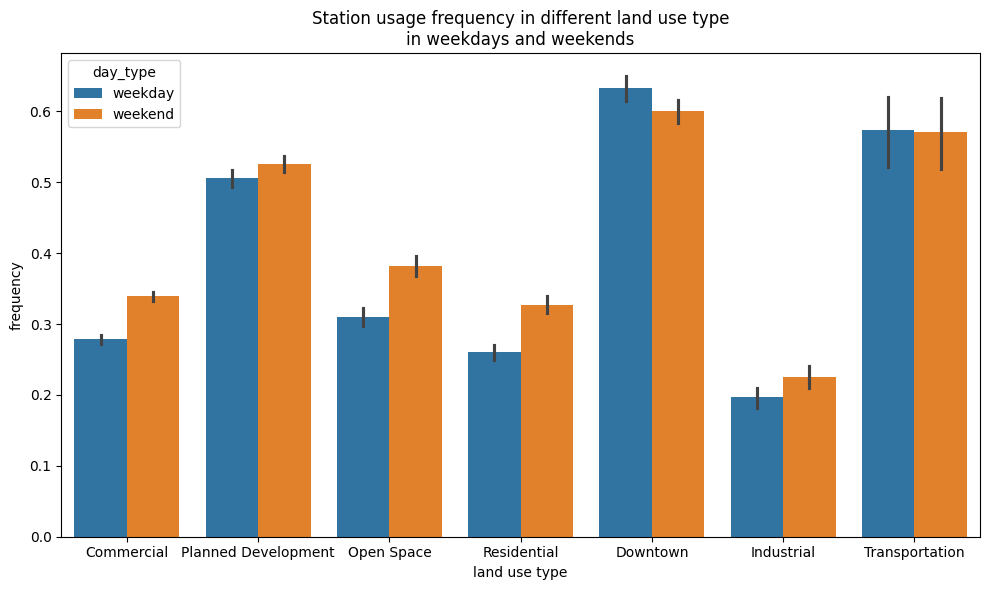

In [21]:
# draw usage frequency bar plot to compare the difference between weekday and weekend for each land use type. 
subset = joined.copy()
subset.loc[subset["day_type"] == "weekday", "freq"] = subset.loc[subset["day_type"] == "weekday", "days"] / 66
subset.loc[subset["day_type"] == "weekend", "freq"] = subset.loc[subset["day_type"] == "weekend", "days"] / 26

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data = subset, x = "category", y = "freq", hue = "day_type", ax = ax)
ax.set_title(f"Station usage frequency in different land use type\nin weekdays and weekends")
ax.set_xlabel("land use type")
ax.set_ylabel("frequency")
plt.tight_layout()
plt.show()

In [22]:
# calculate total trips of classic and electric bikes for stations of each land use type on weekend or weekday over three month
# convert to percentage for comparison
bike_types_pct = joined.groupby(["category", "day_type"]).agg(electric_total_trips = ("hourly_total_electric_trips_sum", "sum"),
                                                              classic_total_trips = ("hourly_total_classic_trips_sum", "sum")).reset_index()
bike_types_pct["total"] = bike_types_pct["electric_total_trips"] + bike_types_pct["classic_total_trips"]
bike_types_pct["electric_total_trips_pct"] = bike_types_pct["electric_total_trips"] / bike_types_pct["total"]
bike_types_pct["classic_total_trips_pct"] = bike_types_pct["classic_total_trips"] / bike_types_pct["total"]
bike_types_pct.head()

,category,day_type,electric_total_trips,classic_total_trips,total,electric_total_trips_pct,classic_total_trips_pct
0,Commercial,weekday,415022.0,287449.0,702471.0,0.590803,0.409197
1,Commercial,weekend,183012.0,135568.0,318580.0,0.574462,0.425538
2,Downtown,weekday,190700.0,139363.0,330063.0,0.577768,0.422232
3,Downtown,weekend,53667.0,48051.0,101718.0,0.527606,0.472394
4,Industrial,weekday,24220.0,14687.0,38907.0,0.622510,0.377490


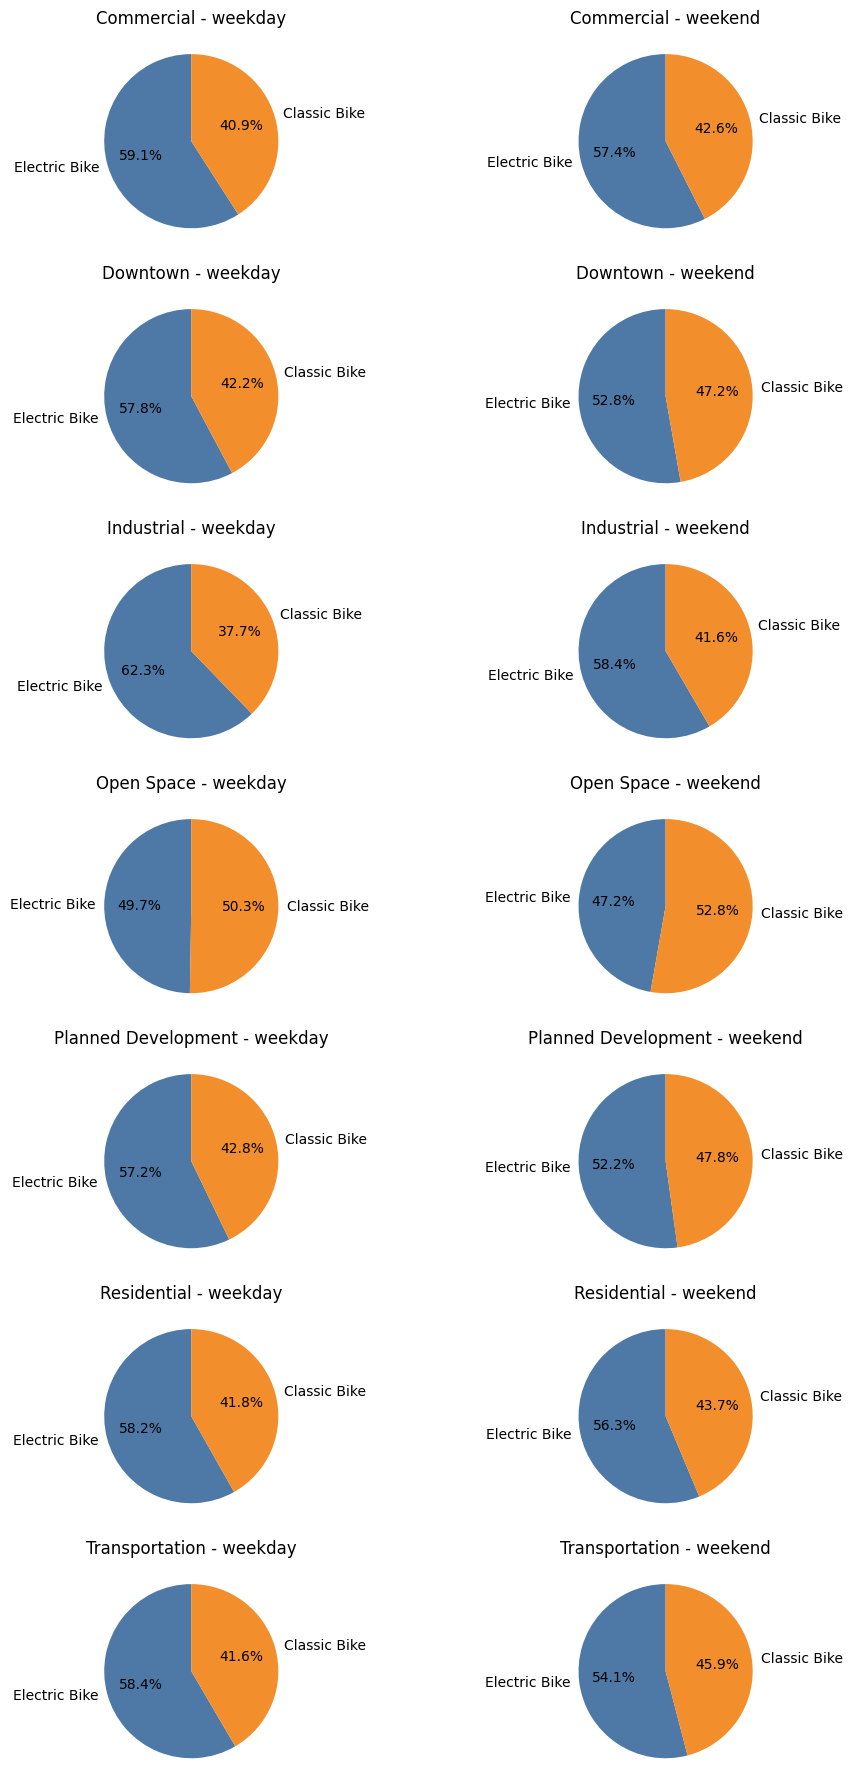

In [23]:
# This code generates pie charts to compare the proportion of electric bike trips versus classic bike trips across different land use categories,
# separately for weekdays and weekends.
cats = bike_types_pct["category"].unique()
day_types = ["weekday", "weekend"]

fig, ax = plt.subplots(len(cats), 2, figsize=(10, 18))

for i, cat in enumerate(cats):
    for j, day in enumerate(day_types):

        subset = bike_types_pct[(bike_types_pct["category"] == cat) & (bike_types_pct["day_type"] == day)]

        values = [
            subset["electric_total_trips_pct"].values[0],
            subset["classic_total_trips_pct"].values[0]
        ]
        labels = ["Electric Bike", "Classic Bike"]
        colors = ["#4E79A7", "#F28E2B"]

        ax[i, j].pie(
            values,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors
        )
        ax[i, j].set_title(f"{cat} - {day}", fontsize=12)

plt.tight_layout()
plt.show()


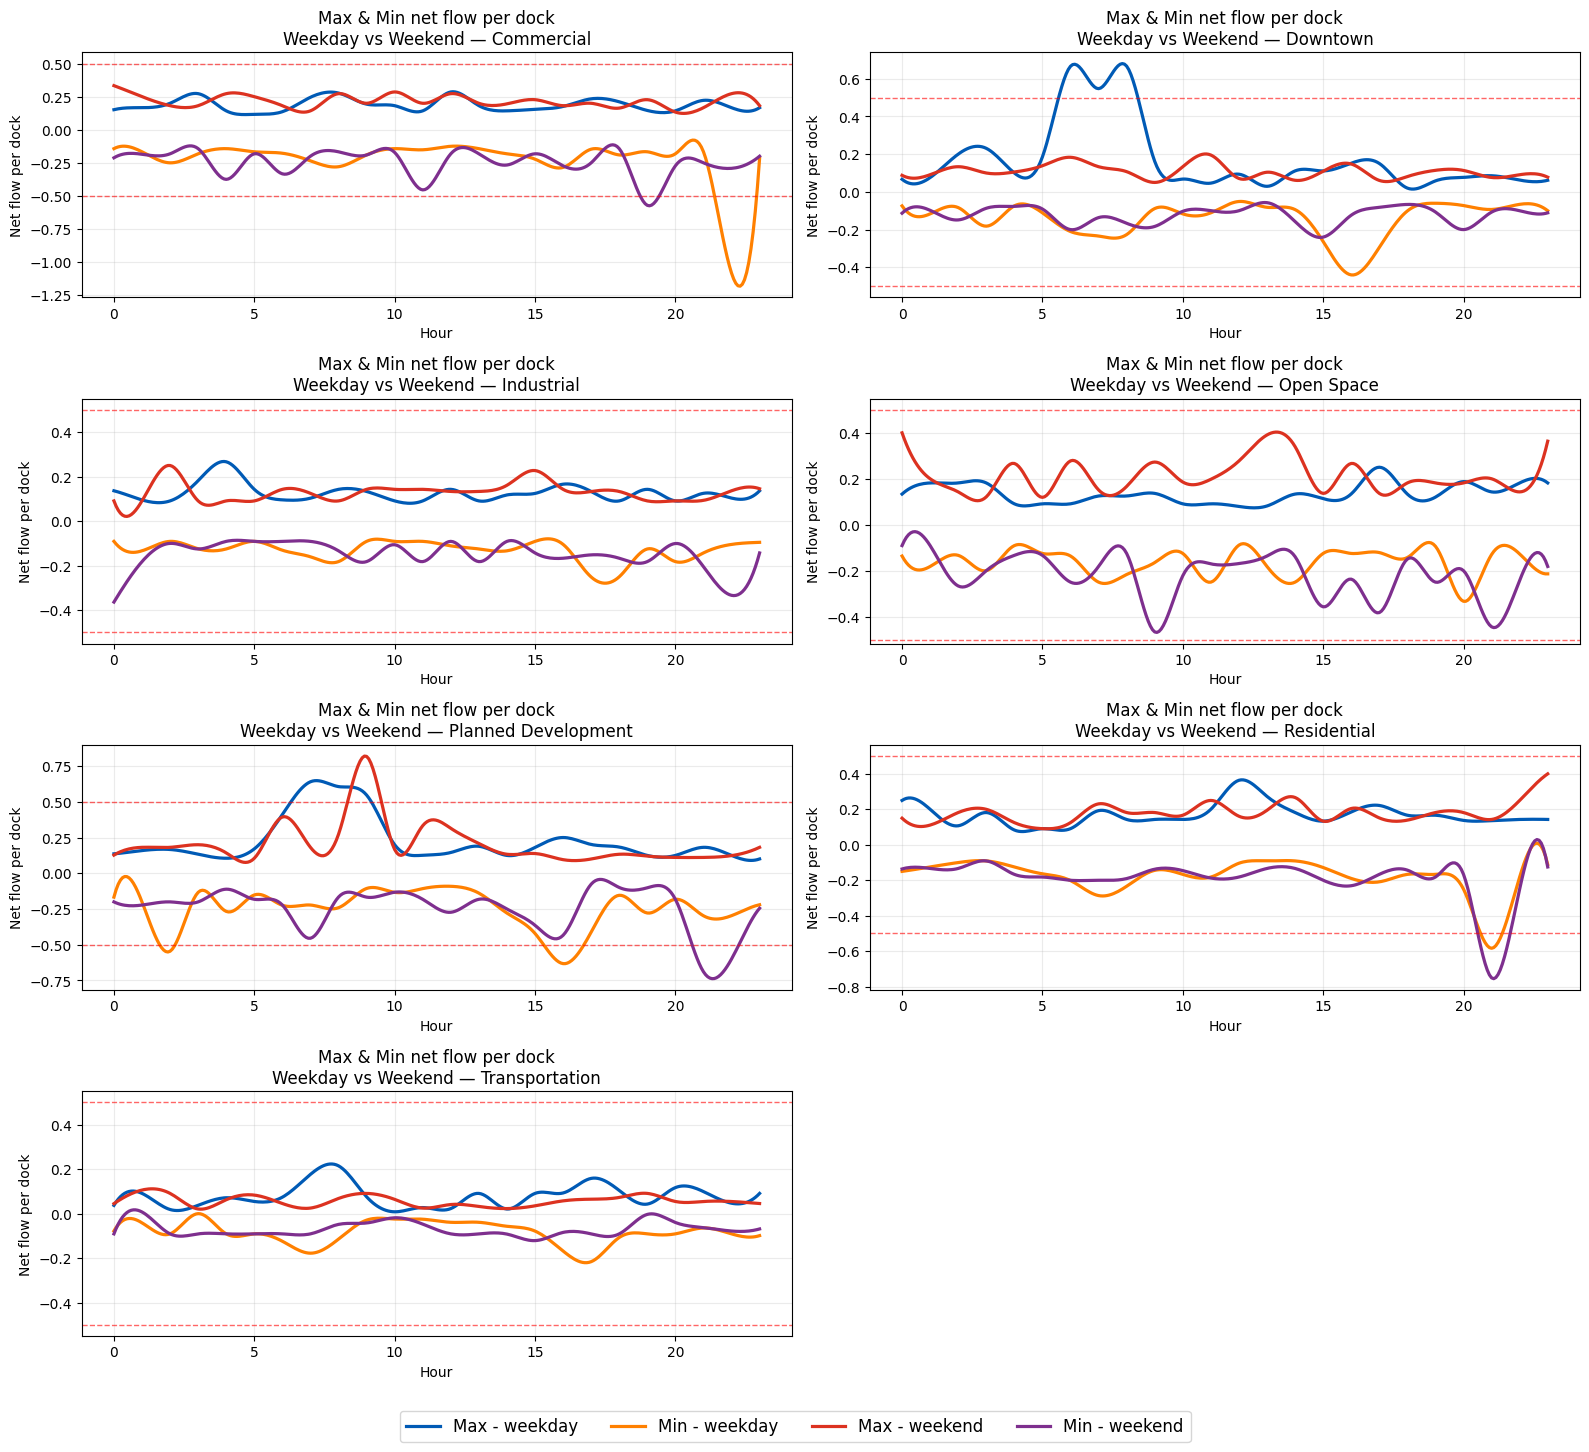

In [25]:
# This block visualizes the hourly maximum and minimum net flow per dock across different station land use categories, comparing weekdays and weekends.
# For each category, net flow per dock is aggregated by hour and summarized using max and min statistics to capture extreme imbalance behavior.
# Spline interpolation is applied to smooth the hourly curves for clearer visualization of temporal patterns.

from scipy.interpolate import make_interp_spline

fig, ax = plt.subplots(4, 2, figsize=(16, 14))
ax = ax.flatten()
fig.delaxes(ax[-1])
ax = ax[:-1]

palette_max = {"weekday": "#005AB5", "weekend": "#DC3220"}   
palette_min = {"weekday": "#FF8000", "weekend": "#7E2F8E"}  

def smooth_line(x, y):
    """Spline interpolation for smooth curves"""
    x_new = np.linspace(min(x), max(x), 300)
    spl = make_interp_spline(x, y, k=3)
    y_new = spl(x_new)
    return x_new, y_new

for i, cat in enumerate(cats):
    subset = joined[joined["category"] == cat]

    for day in ["weekday", "weekend"]:

        for mode, palette in zip(["max", "min"], [palette_max, palette_min]):
            
            y = subset[subset["day_type"] == day].groupby("hour")["net_flow_per_dock"].agg(mode)
            x = y.index.values
            y = y.values
            
            x_smooth, y_smooth = smooth_line(x, y)

            ax[i].plot(
                x_smooth,
                y_smooth,
                color=palette[day],
                linewidth=2.3,
                label=f"{mode.capitalize()} - {day}" if i == 0 else None
            )

    ax[i].set_title(f"Max & Min net flow per dock\nWeekday vs Weekend — {cat}")
    ax[i].set_xlabel("Hour")
    ax[i].set_ylabel("Net flow per dock")
    ax[i].grid(alpha=0.25)

    ax[i].axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1,
    alpha=0.6
    )

    ax[i].axhline(
        y=-0.5,
        color="red",
        linestyle="--",
        linewidth=1,
        alpha=0.6
    )
    
fig.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=4,
    fontsize=12
)

plt.tight_layout()
plt.show()

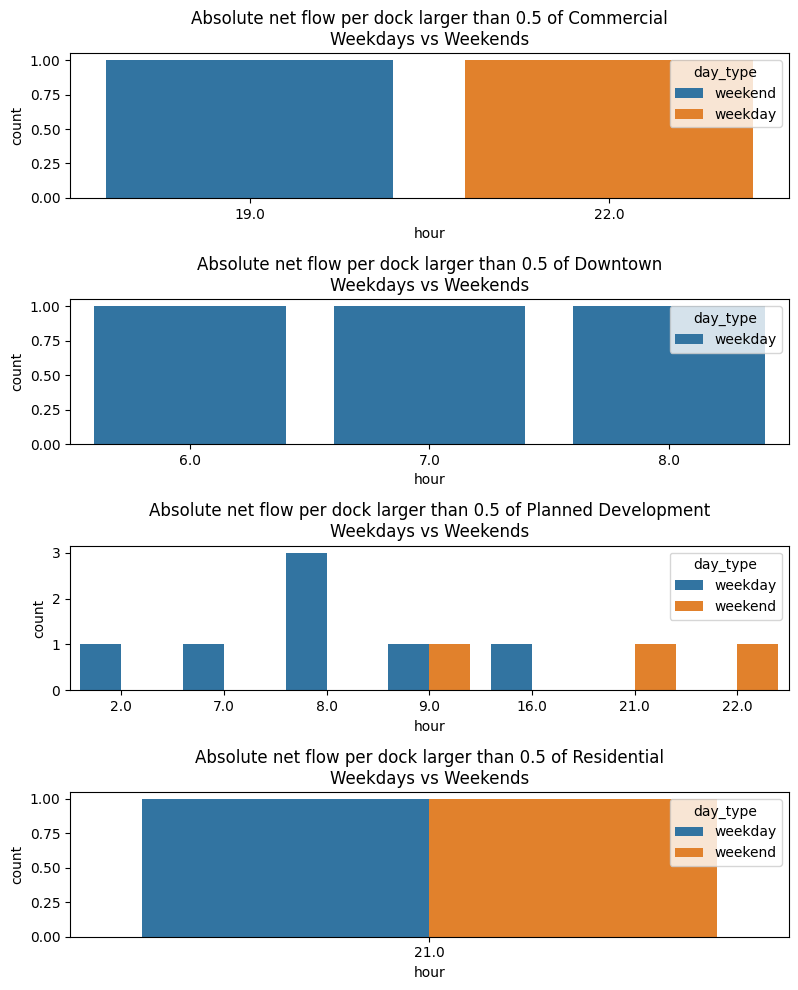

In [ ]:
# This code identifies time periods when stations experience extreme operational
# stress, defined as an absolute net flow per dock greater than 0.5.
#
# First, the data is filtered to retain only station–hour observations
# with unusually large inflow or outflow relative to docking capacity.
#
# Next, these extreme observations are summarized by counting the number of
# distinct stations experiencing extreme net flow at each hour, separately
# for weekdays and weekends and across different land use types.
#
# The resulting bar plots show, for each land use category, how many stations
# simultaneously experience extreme net flow per dock at each hour of the day.
# This visualization highlights when operational stress is temporally
# concentrated and whether it affects multiple stations at the same time.

subset = joined[(joined["net_flow_per_dock"] > 0.5) | (joined["net_flow_per_dock"] < -0.5)]
subset2 = subset.groupby(["category", "day_type", "hour"]).agg(count = ("station_name", "nunique")).reset_index()
cats = subset2["category"].unique()
rows = len(cats)
fig, ax = plt.subplots(rows, 1, figsize = (8, 10))
ax = ax.flatten()
for i, cat in enumerate(cats):
    subsubset = subset2[subset2["category"] == cat]
    sns.barplot(data = subsubset, x = "hour", y = "count", hue = "day_type", ax = ax[i])
    ax[i].set_title(f"Absolute net flow per dock larger than 0.5 of {cat}\nWeekdays vs Weekends")
    ax[i].set_xlabel("hour")
    ax[i].set_ylabel("count") 
plt.tight_layout()
plt.show()
